In [2587]:
%reset -f 

In [2588]:
#ECM: European Centre for Medium-Range Weather Forecasts

In [2589]:
import pandas as pd
import numpy as np
from scipy import stats
import calendar

from sklearn.metrics import r2_score
from IPython.display import display

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 100)
pd.options.display.precision = 2

# visualization
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
%matplotlib inline

In [2590]:
#define paths

WIND_ACTUAl = 'wind_actual_generation.csv'
WIND_FORECAST = 'wind_forecast.csv'

# Load Data

### 1) Load actual data

In [2591]:
#read file
actual = pd.read_csv(WIND_ACTUAl, sep=',', header=None)
#name columns
actual.columns = ['ts', 'actual']
#parse date and sort
actual['ts'] = pd.to_datetime(actual['ts'], utc=True).sort_values()

In [2592]:
actual.head();

In [2593]:
actual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630523 entries, 0 to 630522
Data columns (total 2 columns):
ts        630523 non-null datetime64[ns, UTC]
actual    630523 non-null float64
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 9.6 MB


In [2594]:
#set date as index
actual = actual.set_index('ts')

In [2595]:
actual.head()

,actual
ts,
2013-09-08 03:55:00+00:00,2680.85
2013-09-08 04:00:00+00:00,2680.85
2013-09-08 04:05:00+00:00,2738.27
2013-09-08 04:10:00+00:00,2811.47
2013-09-08 04:15:00+00:00,2967.41


### 2) Load forecasted data

In [2596]:
#load wind forecast values
forecast = pd.read_csv(WIND_FORECAST, sep=',')
#parse date, and sort
forecast['ts'] = pd.to_datetime(forecast['ts'], utc=True).sort_values()

In [2597]:
forecast.head();

In [2598]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59323 entries, 0 to 59322
Data columns (total 3 columns):
ts     59323 non-null datetime64[ns, UTC]
ecm    59322 non-null float64
mda    58559 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 1.4 MB


In [2599]:
#set date as index
forecast = forecast.set_index('ts')

In [2600]:
forecast.head()

,ecm,mda
ts,,
2013-01-02 07:00:00+00:00,1733.0,2039.6
2013-01-02 08:00:00+00:00,1780.9,2137.3
2013-01-02 09:00:00+00:00,1739.6,2090.2
2013-01-02 10:00:00+00:00,1738.8,2169.3
2013-01-02 11:00:00+00:00,1552.3,2163.4


# Validation of the input signals

### Data sizes
The actual data is much bigger than the forecasted. 

In [2601]:
print("Num samples in actual data:", actual.shape[0])
print("Num samples in forecast data:", forecast.shape[0])

Num samples in actual data: 630523
Num samples in forecast data: 59323


### Sampling frequency

The reason for the difference in data sizes might be due to the difference in sampling frequency: 
 - The **actual** values are given at **5 minutes** intervals.
 - The **forecasted** values are given at **1 hour** interval. 
 
(Bigger intervals, as can be seen in the max row, are the result of a gap in the sampling)
 

In [2602]:
#get frequency of actual values
actual_diff = pd.Series(actual.index[1:] - actual.index[:-1])

#get frequency of forecast values
forecast_diff = pd.Series(forecast.index[1:] - forecast.index[:-1])

df = pd.concat([actual_diff,forecast_diff], axis=1).describe(percentiles=[0.99])
df.columns = ['actual freq','forecast freq']
df

,actual freq,forecast freq
count,630522,59322
mean,0 days 00:05:05.314168,0 days 01:00:08.981490
std,0 days 00:51:34.179435,0 days 00:14:33.648570
min,0 days 00:05:00,0 days 01:00:00
50%,0 days 00:05:00,0 days 01:00:00
99%,0 days 00:05:00,0 days 01:00:00
max,27 days 21:35:00,1 days 06:00:00


In [2603]:
#see where the gap in dates occur 
idx = actual_diff[actual_diff == actual_diff.max()].index[0]
actual.iloc[idx-5:idx+5]

,actual
ts,
2015-09-30 13:35:00+00:00,774.45
2015-09-30 13:40:00+00:00,748.55
2015-09-30 13:45:00+00:00,663.75
2015-09-30 13:50:00+00:00,626.86
2015-09-30 13:55:00+00:00,626.86
2015-09-30 14:00:00+00:00,542.06
2015-10-28 11:35:00+00:00,10012.85
2015-10-28 11:40:00+00:00,10012.85
2015-10-28 11:45:00+00:00,9946.58


In [2604]:
actual.shape[0] / (60/5)

52543.583333333336

### Missing values

- Actual data does not have missing values (see info below). 
- There is **1** missing value in column ECM.
- There are **764** missing value in column MDA.

Remove rows where one of the values is missing.

In [2605]:
print("Num missing values in method ECM:", forecast['ecm'].isna().sum())
print("Num missing values in method MDA:", forecast['mda'].isna().sum())

Num missing values in method ECM: 1
Num missing values in method MDA: 764


In [2606]:
#keep only rows where both values exist
forecast = forecast[forecast['ecm'].notna() & forecast['mda'].notna()]

### Remove outliers

It can be seen in the description and in the plot below that there are ouliers values. For quantile > 0.99  

In [2607]:
#description data
pd.concat([actual, forecast], axis=1).describe(percentiles=[0.25,0.5,0.75, 0.9, 0.99])

,actual,ecm,mda
count,630523.00,58559.00,58559.00
mean,6224.87,5993.61,5992.33
std,3979.97,3754.88,3552.92
min,0.00,0.00,0.00
25%,2996.82,3077.15,3206.50
50%,5596.13,5375.00,5356.00
75%,8846.95,8204.25,8059.05
90%,12069.56,11458.40,11182.00
99%,15996.03,16293.84,15878.42
max,97944.20,20350.00,19587.00


####  Plot actual values - Before removing outliers

Text(0.5, 1.0, 'Time-series of actual wind values (including outliers)')

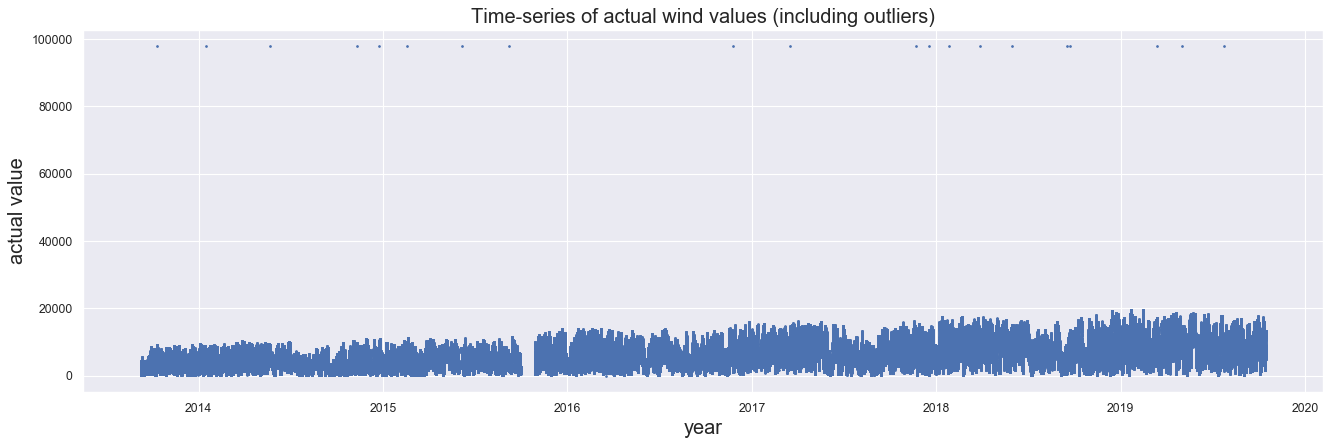

In [2608]:
#plot actual values - before removing outliers
figure(num=None, figsize=(20, 6), dpi=80)
plt.scatter(actual.index, actual['actual'], s=2)
plt.xlabel('year', fontsize=18)
plt.ylabel('actual value', fontsize=18)
plt.title("Time-series of actual wind values (including outliers)", fontsize=18)

#### Actual values - remove outliers
We can see in the plot above several points which are **> 80,000**. These are probably outliers, and they have the same value: **97944.2**. 

To remove outliers, we can either remove these points, or replace their values by the mean/median of their neighbors (neighbors can be samples sampled in same hour). Since there are only 20 outliers, from different days, it will be just enough to remove them. 

In [2609]:
#get outlirers
noise_thershold = 20000
outliers = actual[actual['actual'] > noise_thershold]['actual']

outliers.value_counts()

97944.2    20
Name: actual, dtype: int64

In [2610]:
#remove outliers 
actual = actual[actual['actual'] <= noise_thershold]

####  Plot actual values - After removing outliers

Text(0.5, 1.0, 'Time-series of actual wind values (no outliers)')

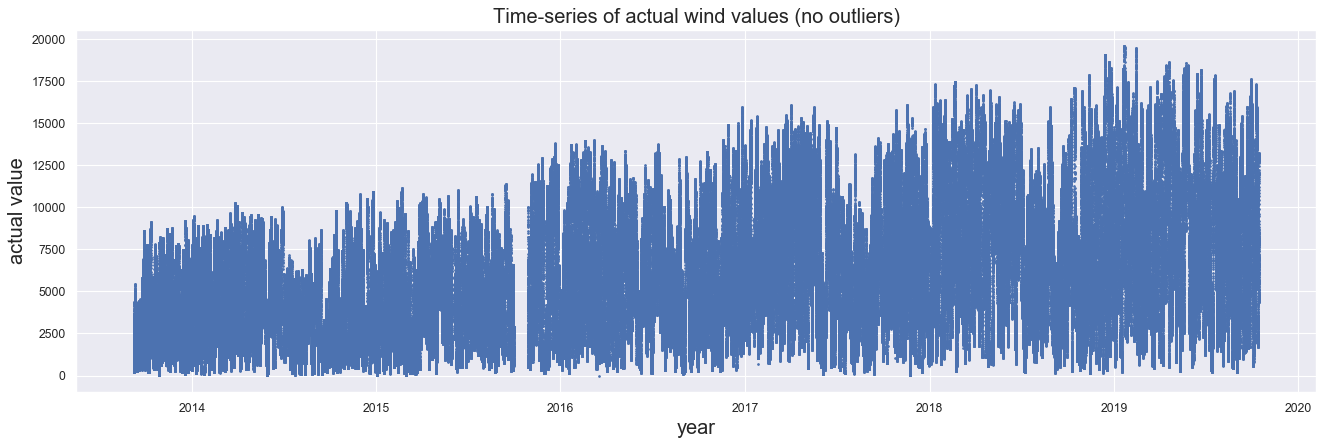

In [2611]:
#plot actual values - after removing outliers
figure(num=None, figsize=(20, 6), dpi=80)
plt.scatter(actual.index, actual['actual'], s=2)
plt.xlabel('year', fontsize=18)
plt.ylabel('actual value', fontsize=18)
plt.title("Time-series of actual wind values (no outliers)", fontsize=18)

#### Plot forecasted values

Text(0, 0.5, 'MDA value')

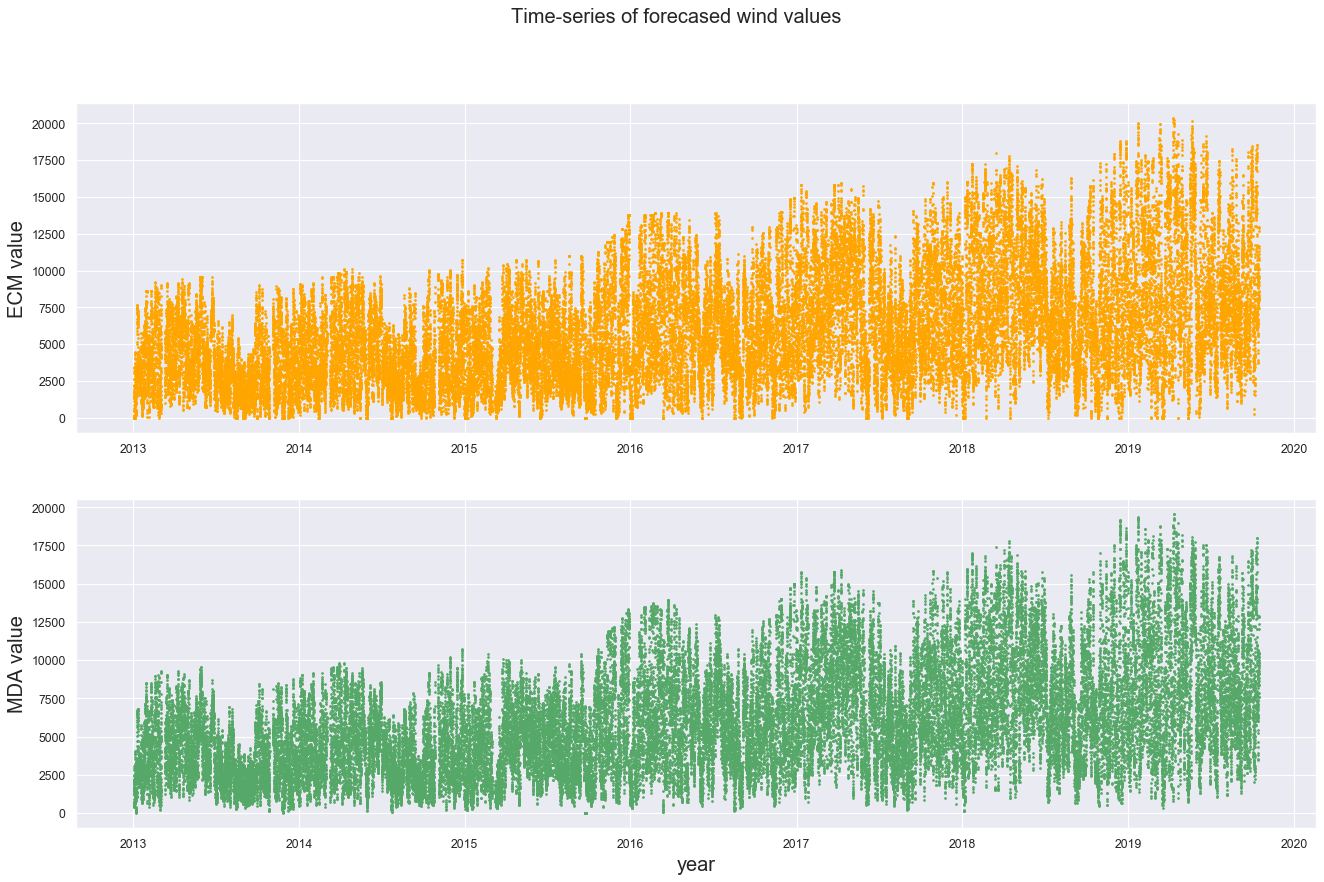

In [2612]:
#plot forecasted values
fig = figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')

fig.suptitle('Time-series of forecased wind values', fontsize=18)

plt.subplot(211)
plt.scatter(forecast.index, forecast['ecm'], color='orange', s=2)
plt.ylabel('ECM value', fontsize=18)

plt.subplot(212)
plt.scatter(forecast.index, forecast['mda'], color='g', s=2)
plt.xlabel('year', fontsize=18)
plt.ylabel('MDA value', fontsize=18)

## Data characteristics

In [2613]:
#description data after cleaning (remove NA and outliers)
pd.concat([actual, forecast], axis=1).describe()

,actual,ecm,mda
count,630503.00,58559.00,58559.00
mean,6221.96,5993.61,5992.33
std,3946.36,3754.88,3552.92
min,0.00,0.00,0.00
25%,2996.78,3077.15,3206.50
50%,5595.96,5375.00,5356.00
75%,8846.56,8204.25,8059.05
max,19588.84,20350.00,19587.00


### Histograms of data

Text(0.5, 0.98, 'Distributions of wind values')

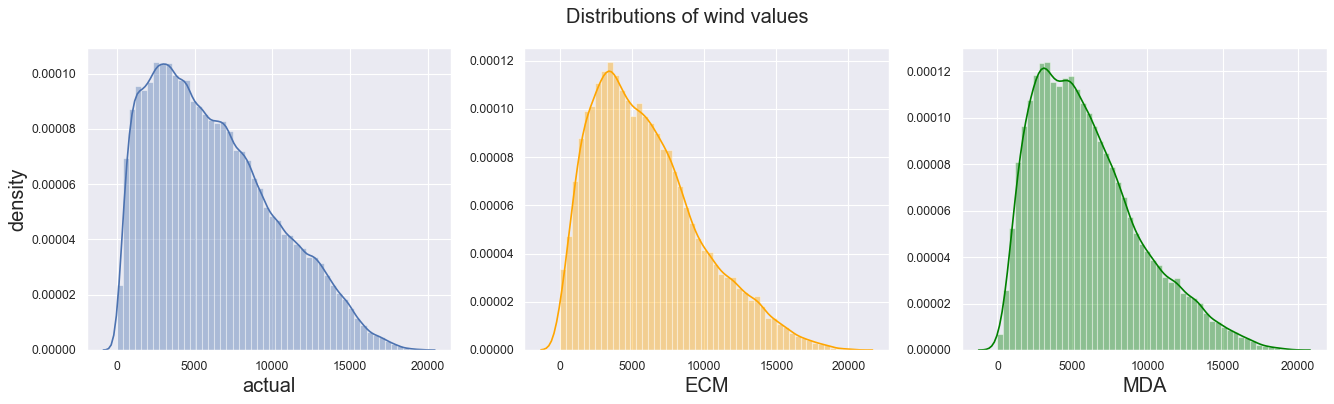

In [2614]:
#histograms of values
fig = figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')


#ECM
plt.subplot(131)
sns.distplot(actual['actual'], color='b')
plt.xlabel("actual", fontsize=18)
plt.ylabel("density", fontsize=18)

#ECM
plt.subplot(132)
sns.distplot(forecast['ecm'], color='orange')
plt.xlabel("ECM", fontsize=18)


#MDA
plt.subplot(133)
sns.distplot(forecast['mda'], color='green')
plt.xlabel("MDA", fontsize=18)

fig.suptitle('Distributions of wind values', fontsize=18)


#### Explore distributions

#### 1. Computes the Kolmogorov-Smirnov statistic on 2 samples.

In [2615]:
# ks_2samp
#a two-sided test for the null hypothesis that 2 independent samples 
#are drawn from the same continuous distribution.

ALPHA = 0.05

#actual VS ECM
s, p = stats.ks_2samp(actual['actual'], forecast['ecm'])
if p < ALPHA:
    print("Actual and ECM data sets are NOT from the same distribution.", "pval:", p)
else:
    print("Actual and ECM data sets are from the same distribution", "pval:", p)

#actual VS MDA
s, p = stats.ks_2samp(actual['actual'], forecast['mda'])
if p < ALPHA:
    print("Actual and MDA data sets are NOT from the same distribution.", "pval:", p)
else:
    print("Actual and MDA data sets are from the same distribution.", "pval:", p)    
    
#ECM VS MDA    
s, p = stats.ks_2samp(forecast['ecm'], forecast['mda'])
if p < ALPHA:
    print("ECM and MDA data sets are NOT from the same distribution.", "pval:", p)
else:
    print("ECM and MDA data sets are from the same distribution.", "pval:", p)


Actual and ECM data sets are NOT from the same distribution. pval: 2.0770409988526857e-88
Actual and MDA data sets are NOT from the same distribution. pval: 7.133092534481233e-136
ECM and MDA data sets are NOT from the same distribution. pval: 5.826228225789862e-20


#### 2. Try to fit distribution

In [2616]:
#kstest
#Perform the Kolmogorov-Smirnov test for goodness of fit.

#gamma distribution (also perform for log-normal)
for data in [actual['actual'], forecast['ecm'], forecast['mda']]:
    param = stats.gamma.fit(data)
    
    goodness_of_fit = stats.kstest(data, 'gamma', param)
    
    if p < ALPHA:
        print("Not from gamma distribution.", "pval:", p)
    else:
        print("From gamma distribution.", "pval:", p)



Not from gamma distribution. pval: 5.826228225789862e-20
Not from gamma distribution. pval: 5.826228225789862e-20
Not from gamma distribution. pval: 5.826228225789862e-20


### Violin plot of all three variabels  
It can be seen that distributions of all three variabels - actual, ECM, and MDA - is quite similar.

Text(0.5, 1.0, 'Box plot of Wind values')

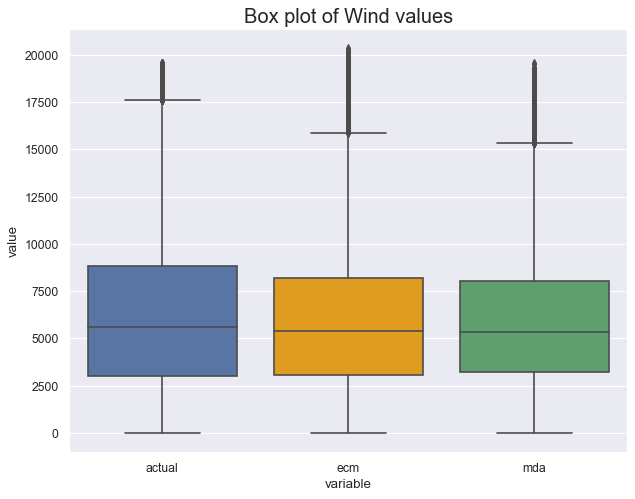

In [2617]:
#plot violin plot for actual and forecasted values
figure(num=None, figsize=(9, 7), dpi=80)
melted = pd.concat([pd.melt(actual), pd.melt(forecast)], axis=0)
ax = sns.boxplot(x="variable", y="value", data=melted, palette=['b','orange', 'g'])
plt.title("Box plot of Wind values", fontsize=18)

Text(0.5, 0.98, 'Distributions of wind values per year')

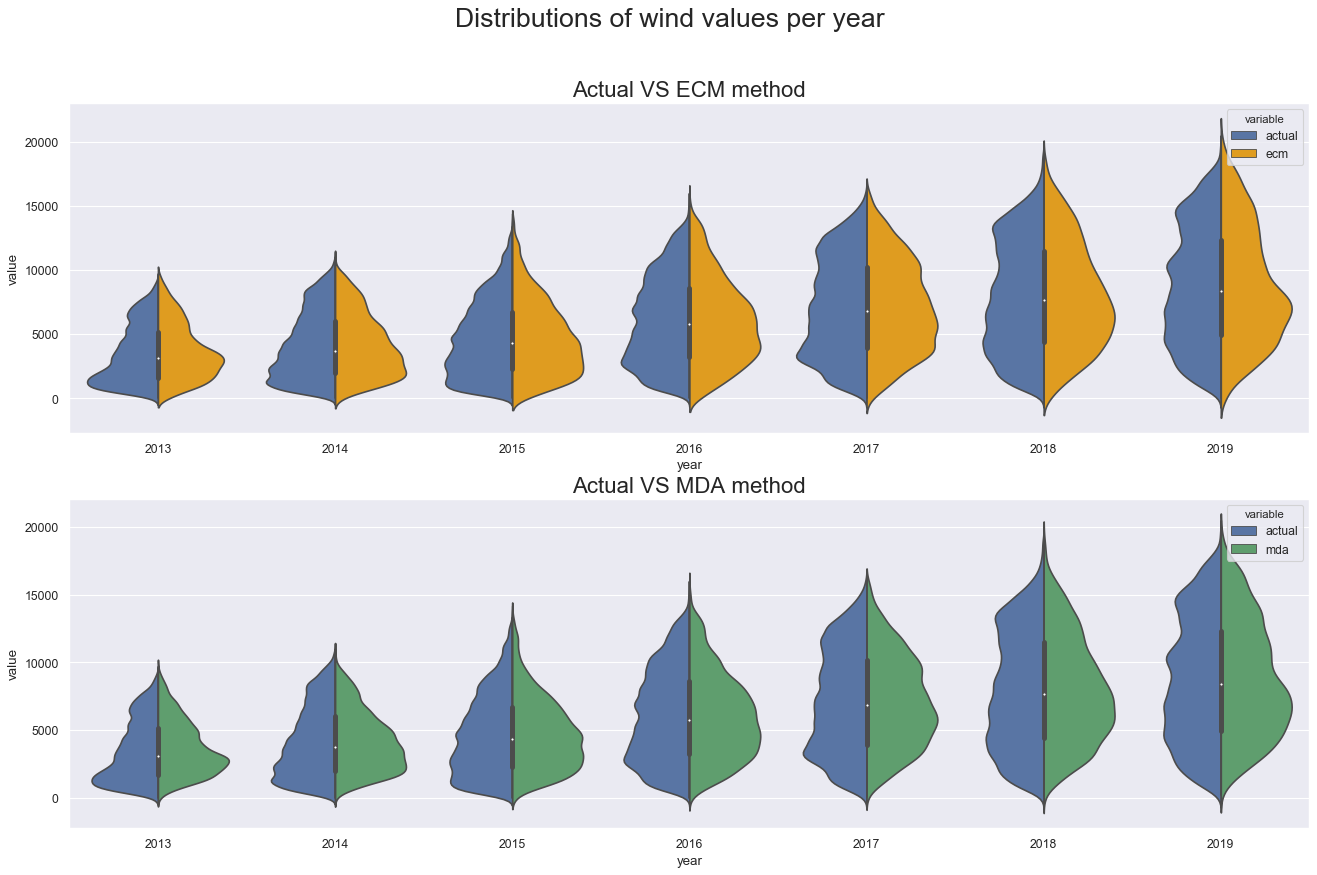

In [2618]:
#plot distributions of wind values per year
fig = figure(num=None, figsize=(20, 12), dpi=80)


#add column of year
actual['year'] = actual.index.year
forecast['year'] = forecast.index.year

#melt
amelted = pd.melt(actual, id_vars=['year'], value_vars=['actual'])
fmelted = pd.melt(forecast, id_vars=['year'], value_vars=['ecm', 'mda'])

#concat
concat = pd.concat([amelted, fmelted], axis=0)

#plot actual VS ECM method
plt.subplot(211)
sns.violinplot(x="year", y="value", hue="variable", 
               data=concat[concat['variable']!='mda'], split=True, palette=['b','orange'])
plt.title("Actual VS ECM method", fontsize=20)

#plot actual VS MDA method
plt.subplot(212)
sns.violinplot(x="year", y="value", hue="variable", 
               data=concat[concat['variable']!='ecm'], split=True, palette=['b','g'])
plt.title("Actual VS MDA method", fontsize=20)

fig.suptitle('Distributions of wind values per year', fontsize=24)

## Evaluate error
Error is defined as: **actual - forecast**.

To evaluate error, we first have to average the actual wind values over an hour, to fit to the sampling frequency of the forecasted values, which is per hour.

In [2619]:
#floor date - remove minutes and seconds
actual['ts_floor'] = actual.index.floor("H")

#group by the floored date, and compute mean (mean per hour)
actual_grouped = actual.groupby(['ts_floor']).mean()

actual_grouped

,actual,year
ts_floor,,
2013-09-08 03:00:00+00:00,2680.85,2013
2013-09-08 04:00:00+00:00,3028.86,2013
2013-09-08 05:00:00+00:00,3246.32,2013
2013-09-08 06:00:00+00:00,2966.42,2013
2013-09-08 07:00:00+00:00,2747.65,2013
...,...,...
2019-10-15 02:00:00+00:00,11933.34,2019
2019-10-15 03:00:00+00:00,12866.25,2019
2019-10-15 04:00:00+00:00,13112.21,2019


In [2620]:
#inner join of actual and forecasted values (join on dtae)
df = pd.concat([actual_grouped, forecast], join='inner', axis=1)
#drop the redundant columns
df = df.drop(columns=['year'])
df

,actual,ecm,mda
2013-09-08 03:00:00+00:00,2680.85,2064.9,2304.9
2013-09-08 04:00:00+00:00,3028.86,2187.2,2617.9
2013-09-08 05:00:00+00:00,3246.32,2143.0,2682.2
2013-09-08 06:00:00+00:00,2966.42,2236.0,2726.1
2013-09-08 07:00:00+00:00,2747.65,2254.6,2601.6
...,...,...,...
2019-10-15 02:00:00+00:00,11933.34,10336.0,10039.0
2019-10-15 03:00:00+00:00,12866.25,10818.0,10618.0
2019-10-15 04:00:00+00:00,13112.21,10996.0,10677.0
2019-10-15 05:00:00+00:00,12844.88,10829.0,10418.0


In [2621]:
#compute error of method ECM
df['error_ecm'] = df['actual'] - df['ecm']

#compute error of method MDA
df['error_mda'] = df['actual'] - df['mda']

df.describe()

,actual,ecm,mda,error_ecm,error_mda
count,51823.00,51823.00,51823.00,51823.00,51823.00
mean,6250.71,6260.29,6256.67,-9.58,-5.96
std,3947.93,3826.28,3615.90,1552.16,1494.97
min,26.75,0.00,4.12,-8432.67,-7400.49
25%,3025.82,3281.00,3425.00,-883.27,-907.31
50%,5634.10,5666.00,5656.00,15.06,-33.25
75%,8890.14,8576.95,8418.00,915.50,920.17
max,19530.50,20350.00,19587.00,8779.02,8457.02


### Plot errors

Text(0, 0.5, 'MDA errors')

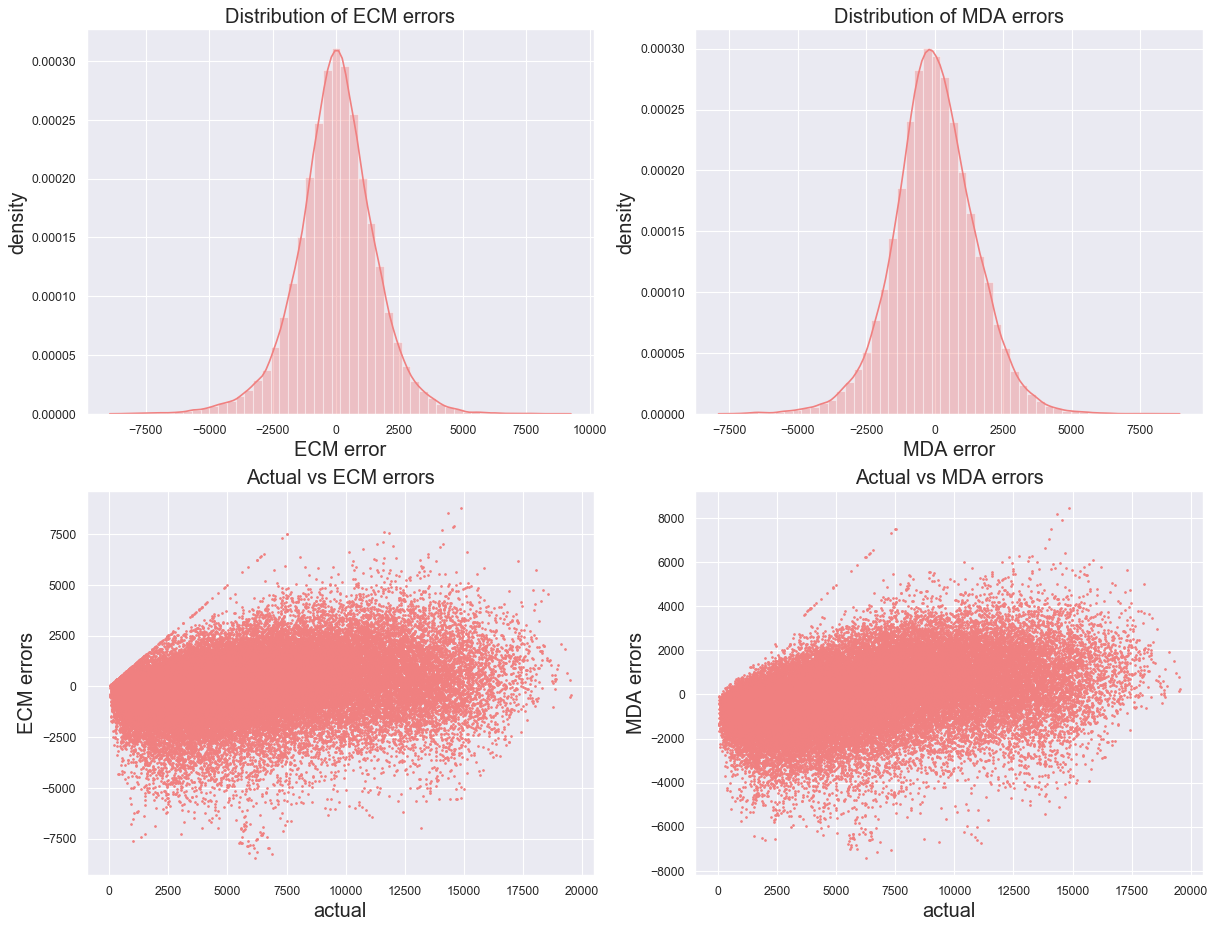

In [2622]:
#scatter plot of errors
fig = figure(num=None, figsize=(18, 14), dpi=80, facecolor='w', edgecolor='k')

#distibutions of errors

#ECM
plt.subplot(221)
sns.distplot(df['error_ecm'], color='lightcoral')
plt.title("Distribution of ECM errors", fontsize=18)
plt.xlabel("ECM error", fontsize=18)
plt.ylabel("density", fontsize=18)

#MDA
plt.subplot(222)
sns.distplot(df['error_mda'], color='lightcoral')
plt.title("Distribution of MDA errors", fontsize=18)
plt.xlabel("MDA error", fontsize=18)
plt.ylabel("density", fontsize=18)

#scatter plot of actual VS errors

#ECM
plt.subplot(223)
plt.scatter(df['actual'], df['error_ecm'], s=2,  c='lightcoral')
plt.title("Actual vs ECM errors", fontsize=18)
plt.xlabel("actual", fontsize=18)
plt.ylabel("ECM errors", fontsize=18)

#MDA
plt.subplot(224)
plt.scatter(df['actual'], df['error_mda'], s=2,  c='lightcoral')
plt.title("Actual vs MDA errors", fontsize=18)
plt.xlabel("actual", fontsize=18)
plt.ylabel("MDA errors", fontsize=18)


#### Distribution of errors

In [2623]:
#test if error come from the normal distribution 

for method in ['ecm', 'mda']:
    s, p = stats.normaltest(df["error_" + method])
    if p < ALPHA:
        print("{} errors are NOT normally distributed.".format(method), "pval:", p)
    else:
        print("{} errors are NOT normally distributed.".format(method), "pval:", p)

ecm errors are NOT normally distributed. pval: 0.0
mda errors are NOT normally distributed. pval: 1.9631821200598467e-232


### A quantitative analysis of the performance of the forecasts

In [2624]:
#Mean Absolute Error (MAE)
mean_absolute_ecm = df['error_ecm'].abs().mean()
mean_absolute_mda = df['error_mda'].abs().mean()

#Root Mean Squared Error (RMSE)
mean_squared_ecm = (df['error_ecm'] ** 2).mean() ** 0.5
mean_squared_mda = (df['error_mda'] ** 2).mean() ** 0.5

#R square 
r2_ecm = r2_score(df['actual'], df['ecm'])
r2_mda = r2_score(df['actual'], df['mda'])  

#combine into a dataframe
pd.DataFrame({"ECM": [mean_absolute_ecm, mean_squared_ecm, r2_ecm], 
              "MDA": [mean_absolute_mda, mean_squared_mda, r2_mda],}, 
             index=["MAE", "RMSE", "R^2"])


,ECM,MDA
MAE,1166.21,1147.81
RMSE,1552.17,1494.96
R^2,0.85,0.86


### Scatter plot of forecasted VS actual

Text(0, 0.5, 'MDA')

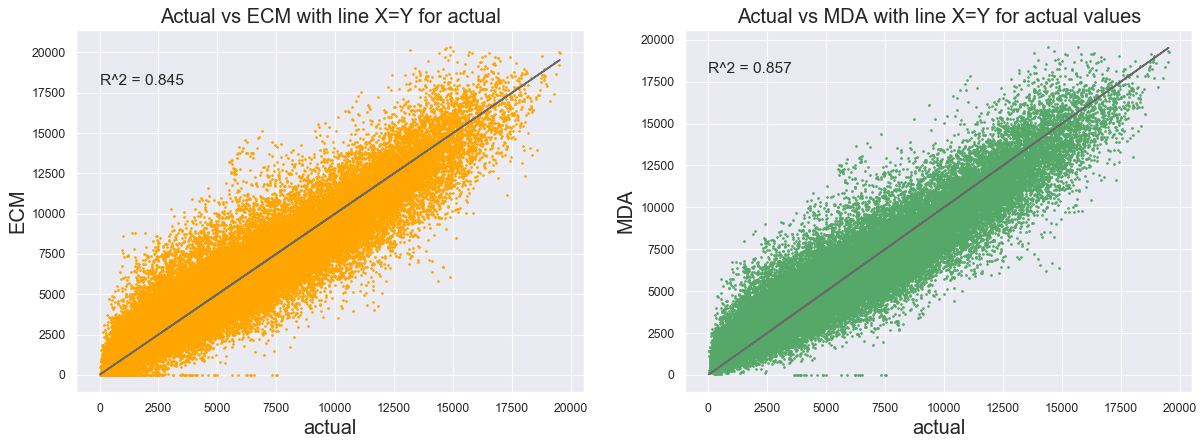

In [2625]:
#scatter plot of forecasted values with line for actual values,
fig = figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')

#ECM
plt.subplot(121)
plt.plot(df['actual'], df['actual'], color='dimgrey')
plt.scatter(df['actual'], df['ecm'], s=2, c='orange')
plt.text(0, 18000, "R^2 = {:0.3f}".format(r2_ecm), fontsize=14)
plt.title("Actual vs ECM with line X=Y for actual", fontsize=18)
plt.xlabel("actual", fontsize=18)
plt.ylabel("ECM", fontsize=18)

#MDA
plt.subplot(122)
plt.plot(df['actual'], df['actual'], color='dimgrey')
plt.scatter(df['actual'], df['mda'], s=2, c='g')
plt.text(0, 18000, "R^2 = {:0.3f}".format(r2_mda), fontsize=14)
plt.title("Actual vs MDA with line X=Y for actual values", fontsize=18)
plt.xlabel("actual", fontsize=18)
plt.ylabel("MDA", fontsize=18)

### Performance in different periods and in different ranges of the wind signal

#### 1. Performance in different ranges of the wind signal

In [2626]:
#compute MAE, RMSE and R^2 for each subset of data 
def f(x, method): 
    d = {} 
    d['MAE_' + method] = x["error_" + method].abs().mean()
    d['RMSE_' + method] = (x["error_" + method] ** 2).mean() ** 0.5
    d['R^2_' + method] = r2_score(x['actual'], x[method])
    return pd.Series(d)

In [2627]:
#performance in different ranges of the wind signal

Q = 10 #number of quntiles  

#discretize variable into equal-sized buckets based on sample quantiles of actual values
q_ecm = pd.qcut(df['actual'], q=Q, precision=0)

#compute errors measures 
ecm = df.groupby(q_ecm).apply(f, method='ecm')
mda = df.groupby(q_ecm).apply(f, method='mda')
    
#concat
errors_quan = pd.concat([ecm, mda], axis=1)

#change index name
errors_quan.index.names = ['values range']

errors_quan

,MAE_ecm,RMSE_ecm,R^2_ecm,MAE_mda,RMSE_mda,R^2_mda
values range,,,,,,
"(26.0, 1499.0]",791.55,1103.75,-8.32,925.75,1192.73,-9.88
"(1499.0, 2536.0]",991.08,1376.08,-20.01,1010.68,1367.94,-19.76
"(2536.0, 3503.0]",1042.73,1416.89,-24.82,990.07,1328.21,-21.68
"(3503.0, 4513.0]",1091.71,1461.46,-23.65,1010.90,1335.55,-19.59
"(4513.0, 5634.0]",1115.96,1472.71,-19.41,1044.70,1373.54,-16.75
"(5634.0, 6839.0]",1217.64,1629.80,-20.79,1122.44,1485.22,-17.10
"(6839.0, 8153.0]",1248.77,1608.00,-16.89,1209.35,1528.38,-15.16
"(8153.0, 9775.0]",1281.24,1625.88,-11.12,1281.82,1594.50,-10.65
"(9775.0, 12111.0]",1423.38,1800.72,-6.30,1403.72,1742.98,-5.84


#### test the hypothesis that the RMSEs of ECM and MDA have the same population mean, using ANOVA test.

In [2649]:
stats.f_oneway(errors_quan['RMSE_ecm'], errors_quan['RMSE_mda'])

Ttest_indResult(statistic=0.5786311787944511, pvalue=0.5700081872517524)

Text(0, 0.5, 'RMSE')

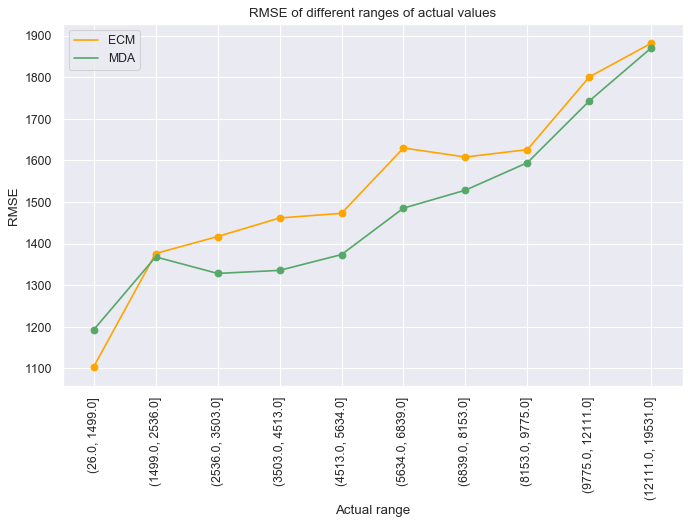

In [2628]:
#scatter plot of forecasted values with line for actual values,
fig = figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

#plot RMSE for ECM 
plt.plot(errors_quan['RMSE_ecm'].values, color='orange', label="ECM")
plt.scatter(range(Q), errors_quan['RMSE_ecm'].values, color='orange')

#plot RMSE for ECM 
plt.plot(errors_quan['RMSE_mda'].values, color='g', label="MDA")
plt.scatter(range(Q), errors_quan['RMSE_mda'].values, color='g')

##add legend
plt.legend(loc="upper left")
plt.xticks(range(Q), errors_quan.index.values, rotation='vertical')

plt.title("RMSE of different ranges of actual values")
plt.xlabel("Actual range")
plt.ylabel("RMSE")

#### 2. Performance in different periods

In [2629]:
#per month

#compute error measures per month
ecm = df.groupby(df.index.month).apply(f, method='ecm')
mda = df.groupby(df.index.month).apply(f, method='mda')

#change index name
errors_month = pd.concat([ecm, mda], axis=1)
errors_month.index.names = ['month']

errors_month

,MAE_ecm,RMSE_ecm,R^2_ecm,MAE_mda,RMSE_mda,R^2_mda
month,,,,,,
1,1222.56,1605.65,0.85,1210.39,1578.54,0.86
2,1316.64,1705.85,0.82,1291.74,1650.11,0.83
3,1245.84,1669.03,0.84,1186.80,1545.23,0.86
4,1230.49,1609.84,0.85,1220.10,1569.92,0.85
5,1208.90,1562.10,0.86,1139.44,1438.28,0.88
6,1203.39,1600.97,0.83,1224.28,1573.33,0.84
7,1125.35,1495.92,0.81,1065.37,1386.76,0.84
8,1096.97,1457.51,0.82,1035.44,1360.45,0.84
9,994.36,1368.18,0.85,1011.52,1344.60,0.86


In [2630]:
#per year

#compute error measures per month
ecm = df.groupby(df.index.year).apply(f, method='ecm')
mda = df.groupby(df.index.year).apply(f, method='mda')

#change index name
errors_year = pd.concat([ecm, mda], axis=1)
errors_year.index.names = ['year']

errors_year

,MAE_ecm,RMSE_ecm,R^2_ecm,MAE_mda,RMSE_mda,R^2_mda
year,,,,,,
2013,857.41,1157.94,0.71,897.36,1196.78,0.69
2014,827.15,1100.50,0.81,884.68,1154.05,0.80
2015,1025.30,1423.46,0.76,1038.79,1402.52,0.77
2016,1134.59,1462.44,0.81,1086.33,1397.36,0.83
2017,1227.45,1599.65,0.82,1217.36,1547.86,0.83
2018,1348.84,1739.97,0.83,1323.29,1678.99,0.84
2019,1580.14,2014.00,0.80,1448.88,1827.71,0.84


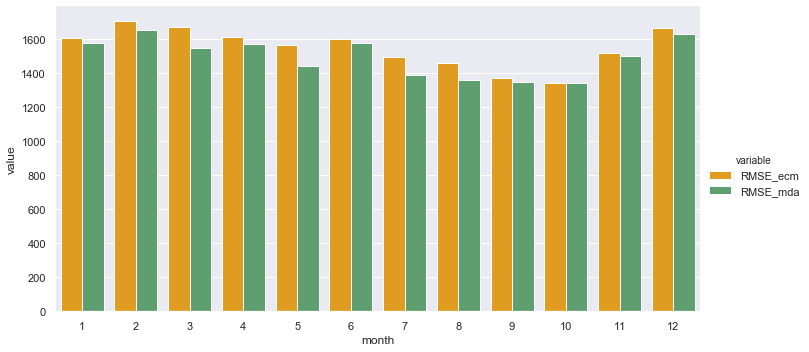

In [2631]:

melted = pd.melt(errors_month.reset_index(), id_vars='month',value_vars=['RMSE_ecm','RMSE_mda'])

sns.catplot(x="month", y="value",
                hue="variable", 
                data=melted, kind="bar",
           height=5, aspect=2, palette={'orange', 'g'})

Text(0, 0.5, 'mean')

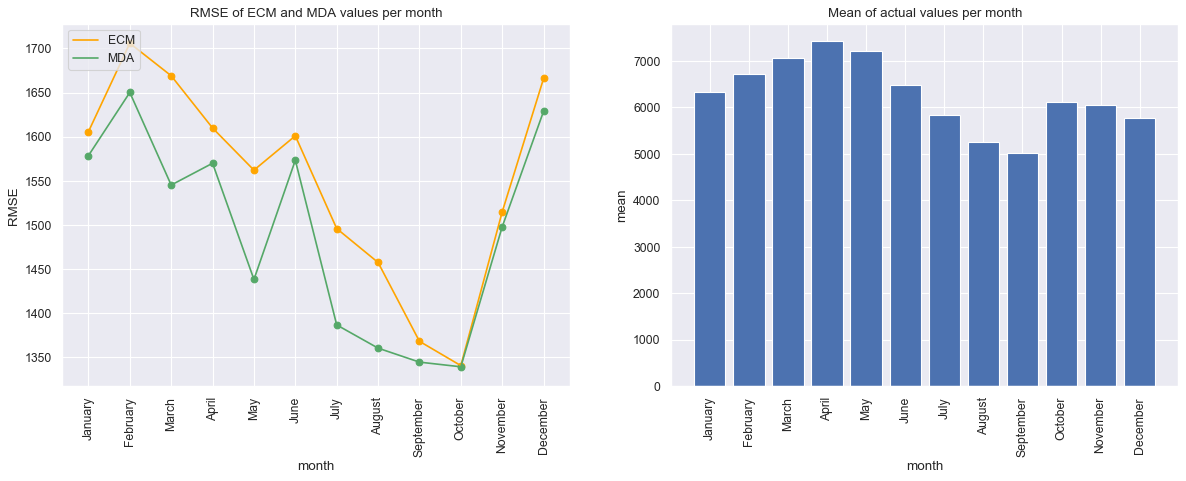

In [2633]:
#plot error measures per month 
fig = figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')

#get mean of actual values per month 
mean = df.groupby(df.index.month)['actual'].mean() 

#get months names 
month_names = [calendar.month_name[month_idx] for month_idx in range(1,13)]

#left figure
#########################
plt.subplot(121)
plt.plot(errors_month.index, errors_month['RMSE_ecm'].values, color='orange', label="ECM")
plt.scatter(errors_month.index, errors_month['RMSE_ecm'].values, color='orange')

#plot RMSE for ECM 
plt.plot(errors_month.index, errors_month['RMSE_mda'].values, color='g', label="MDA")
plt.scatter(errors_month.index, errors_month['RMSE_mda'].values, color='g')

#labels of x axis
plt.xticks(range(1,13), month_names, rotation='vertical')

##add legend
plt.legend(loc="upper left")

plt.title("RMSE of ECM and MDA values per month")
plt.xlabel("month")
plt.ylabel("RMSE")

#right figure
#########################
plt.subplot(122)
plt.bar(errors_month.index, mean)

#labels of x axis
plt.xticks(range(1,13), month_names, rotation='vertical')

plt.title("Mean of actual values per month")
plt.xlabel("month")
plt.ylabel("mean")


Text(0, 0.5, 'mean')

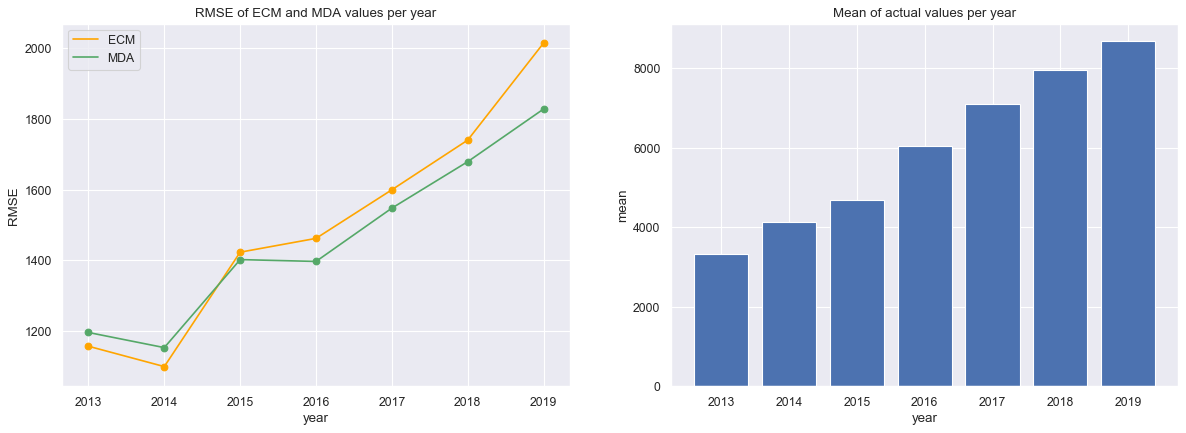

In [2634]:
#plot error measures per year 
fig = figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')

#get mean of actual values per month 
mean = df.groupby(df.index.year)['actual'].mean() 

#left figure
#########################
plt.subplot(121)
plt.plot(errors_year.index, errors_year['RMSE_ecm'].values, color='orange', label="ECM")
plt.scatter(errors_year.index, errors_year['RMSE_ecm'].values, color='orange')

#plot RMSE for ECM 
plt.plot(errors_year.index, errors_year['RMSE_mda'].values, color='g', label="MDA")
plt.scatter(errors_year.index, errors_year['RMSE_mda'].values, color='g')

##add legend
plt.legend(loc="upper left")

plt.title("RMSE of ECM and MDA values per year")
plt.xlabel("year")
plt.ylabel("RMSE")

#right figure
#########################
plt.subplot(122)
plt.bar(errors_year.index, mean)

plt.title("Mean of actual values per year")
plt.xlabel("year")
plt.ylabel("mean")


#### test the hypothesis that the RMSEs of ECM and MDA have the same population mean, using ANOVA test.

In [2651]:
stats.f_oneway(errors_year['RMSE_ecm'], errors_year['RMSE_mda'])
stats.f_oneway(errors_month['RMSE_ecm'], errors_month['RMSE_mda'])

F_onewayResult(statistic=1.4552572468556488, pvalue=0.2404992622931755)

### Write an analysis tool

In [2635]:
'''Provide a utility that given a user defined period (for example a ‘Week’ or ‘Month’) and an evaluation
metric, computes the rolling value of the statist and visualizes the result. Explain why and when you
would use such a utility. Run the utility on the provided forecasts and explain the results.'''


def utility(actual, forecast, period, metric):
    
    '''
    Args:
        actual - series of actual values, index of datetime
        forecast - series of forecasted values, index of datetime (same index as actual)
        period - period time, in the following format: 'xh' (x hours), '30D' (month), '365D' (year)
        metric - evaluation metric. "MAE" for mean absolute error, "RMSE" - for root mean square error
        
    Returns:
        res - series of evaluation metric 
        
    '''
    
    #compute error
    error = actual - forecast
    
    #absolute mean error
    if metric == "MAE":
        res = error.rolling(period).apply(lambda x: x.abs().mean(), raw=False)
    
    #root mean square error
    if metric == "RMSE":
        res = error.rolling(period).apply(lambda x: ((x**2).mean())**0.5, raw=False)

    #visualte 
    plt.plot(res.index, res, color='lightcoral')
    plt.title("{} rolling {} values".format(period, metric))
    plt.xlabel("time")
    plt.ylabel(metric)
    
    return res



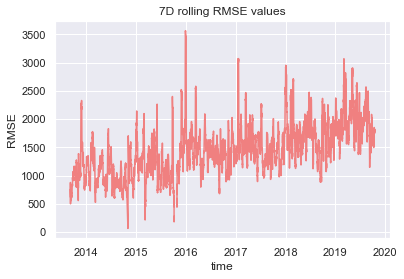

In [2636]:
utility(df['actual'], forecast['ecm'], '7D', "RMSE")

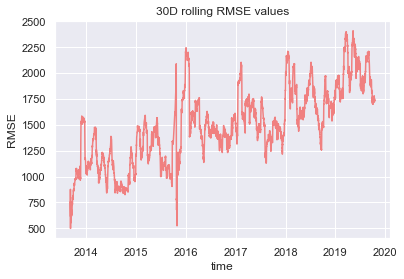

In [2637]:
utility(df['actual'], forecast['ecm'], '30D', "RMSE")

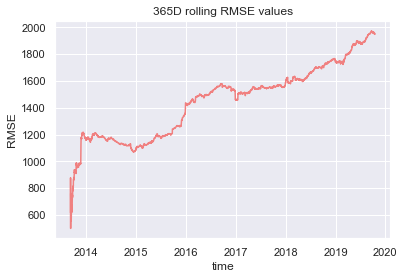

In [2638]:
utility(df['actual'], forecast['ecm'], '365D', "RMSE")

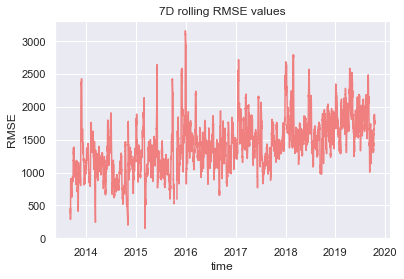

In [2639]:
utility(df['actual'], forecast['mda'], '7D', "RMSE")

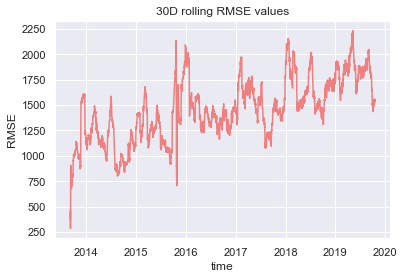

In [2640]:
utility(df['actual'], forecast['mda'], '30D', "RMSE")

2013-01-02 07:00:00+00:00        NaN
2013-01-02 08:00:00+00:00        NaN
2013-01-02 09:00:00+00:00        NaN
2013-01-02 10:00:00+00:00        NaN
2013-01-02 11:00:00+00:00        NaN
                              ...   
2019-10-16 01:00:00+00:00    1803.34
2019-10-16 02:00:00+00:00    1803.44
2019-10-16 03:00:00+00:00    1803.55
2019-10-16 04:00:00+00:00    1803.65
2019-10-16 05:00:00+00:00    1803.74
Length: 58559, dtype: float64

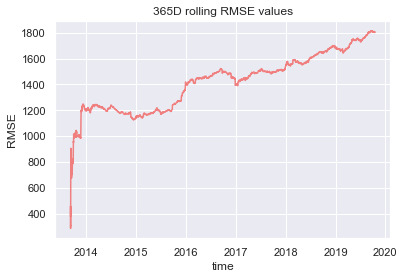

In [2652]:
utility(df['actual'], forecast['mda'], '365D', "RMSE")

## explore r^2

In [2662]:
'''#scatter plot of forecasted values with line for actual values,
fig = figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')


y = df[df['ecm']<df['ecm'].quantile(.5)]['ecm']
x = df['actual'][0:y.shape[0]]

#ECM
plt.subplot(121)
#plt.plot(df['actual'], df['actual'], color='dimgrey')
plt.scatter(x, y, s=2, c='orange')

plt.title("ECM values with line X=Y for actual values")
plt.xlabel("actual")
plt.ylabel("ECM")'''



'#scatter plot of forecasted values with line for actual values,\nfig = figure(num=None, figsize=(18, 6), dpi=80, facecolor=\'w\', edgecolor=\'k\')\n\n\ny = df[df[\'ecm\']<df[\'ecm\'].quantile(.5)][\'ecm\']\nx = df[\'actual\'][0:y.shape[0]]\n\n#ECM\nplt.subplot(121)\n#plt.plot(df[\'actual\'], df[\'actual\'], color=\'dimgrey\')\nplt.scatter(x, y, s=2, c=\'orange\')\n\nplt.title("ECM values with line X=Y for actual values")\nplt.xlabel("actual")\nplt.ylabel("ECM")'

# PART B

In [2666]:
db = pd.read_csv("uswtdb_v2_3_20200109.csv")

In [2667]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63003 entries, 0 to 63002
Data columns (total 25 columns):
case_id       63003 non-null int64
faa_ors       55784 non-null object
faa_asn       56242 non-null object
usgs_pr_id    41334 non-null float64
eia_id        57085 non-null float64
t_state       63003 non-null object
t_county      63003 non-null object
t_fips        63003 non-null int64
p_name        63003 non-null object
p_year        61463 non-null float64
p_tnum        63003 non-null int64
p_cap         58348 non-null float64
t_manu        57308 non-null object
t_model       56739 non-null object
t_cap         57473 non-null float64
t_hh          55213 non-null float64
t_rd          56275 non-null float64
t_rsa         56093 non-null float64
t_ttlh        55211 non-null float64
t_conf_atr    63003 non-null int64
t_conf_loc    63003 non-null int64
t_img_date    42136 non-null object
t_img_srce    63003 non-null object
xlong         63003 non-null float64
ylat          63003 no

In [2668]:
db.head()

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,3073404,NaN,NaN,5806.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,169,16.05,Vestas North America,NaN,95.0,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.35,35.09
1,3073414,NaN,NaN,5778.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,169,16.05,Vestas North America,NaN,95.0,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.35,35.09
2,3011331,NaN,NaN,4951.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,169,16.05,Vestas North America,NaN,95.0,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.36,35.09
3,3001002,NaN,NaN,4950.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,169,16.05,Vestas North America,NaN,95.0,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.36,35.09
4,3073425,NaN,NaN,4957.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,169,16.05,Vestas North America,NaN,95.0,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.36,35.08


In [2669]:
#get data base of The Trent Mesa wind project 
db = db[db['p_name'].str.contains('Trent Mesa')]

In [2676]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 49394 to 53959
Data columns (total 25 columns):
case_id       142 non-null int64
faa_ors       132 non-null object
faa_asn       132 non-null object
usgs_pr_id    132 non-null float64
eia_id        142 non-null float64
t_state       142 non-null object
t_county      142 non-null object
t_fips        142 non-null int64
p_name        142 non-null object
p_year        142 non-null float64
p_tnum        142 non-null int64
p_cap         142 non-null float64
t_manu        142 non-null object
t_model       142 non-null object
t_cap         142 non-null float64
t_hh          142 non-null float64
t_rd          142 non-null float64
t_rsa         142 non-null float64
t_ttlh        142 non-null float64
t_conf_atr    142 non-null int64
t_conf_loc    142 non-null int64
t_img_date    98 non-null object
t_img_srce    142 non-null object
xlong         142 non-null float64
ylat          142 non-null float64
dtypes: float64(11), int64(5), obj

In [2675]:
db['p_name'].value_counts()

Trent Mesa            82
South Trent Mesa      44
Trent Mesa Repower    16
Name: p_name, dtype: int64

In [2680]:
trent =  db[db['p_name'] == 'Trent Mesa']
trent


,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
53862,3086691,48-012097,2017-WTW-10010-OE,31936.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,2/15/2017,Digital Globe,-100.19,32.44
53863,3087003,48-012093,2017-WTW-10014-OE,31809.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,2/15/2017,Digital Globe,-100.20,32.41
53864,3086998,48-012096,2017-WTW-10009-OE,31932.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,2/15/2017,Digital Globe,-100.19,32.44
53865,3091074,48-012108,2017-WTW-9918-OE,31894.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,9/11/2017,Digital Globe,-100.28,32.43
53866,3085525,48-012182,2017-WTW-9965-OE,31842.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,2/15/2017,Digital Globe,-100.22,32.42
53867,3086648,48-012130,2017-WTW-9940-OE,32038.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,9/11/2017,Digital Globe,-100.26,32.46
53868,3090815,48-012115,2017-WTW-9925-OE,31877.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,2/15/2017,Digital Globe,-100.26,32.43
53869,3087079,48-012139,2017-WTW-9949-OE,32034.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,5/18/2017,Digital Globe,-100.24,32.45
53870,3086898,48-012127,2017-WTW-9937-OE,31994.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,9/11/2017,Digital Globe,-100.25,32.45
53871,3086974,48-012141,2017-WTW-9951-OE,32013.0,55968.0,TX,Nolan County,48353,Trent Mesa,2001.0,83,124.5,GE Wind,GE1.5-70.5,1500.0,65.0,70.5,3903.63,100.3,2,3,5/18/2017,Digital Globe,-100.24,32.45


In [2681]:
trent.shape

(82, 25)

t_state: state where turbine is located

t_county: county or county equivalent where turbine is located

t_fips: state and county fips where turbine is located, based on spatial join of turbine points with US state and county shapefile

p_name: name of the wind power project that the turbine is a part of

p_year: Year the wind power project became operational and began providing power. In some cases, the year is estimated based on the year the turbine was erected, which will precede when it became operational, and sometimes fall in the preceding year; -9999 values in the shapefile and blank values in the csv are unknown

p_tnum: number of turbines in the wind power project

p_cap: cumulative capacity of all turbines in the wind power project, in megawatts (MW); -9999 values in the shapefile and blank values in the csv are unknown	

t_manu: turbine manufacturer - name of the original equipment manufacturer of the turbine

t_cap: Turbine rated capacity in kilowatt (kW). The manufacturer's stated output power at rated wind speed. Data from AWEA, manufacturer data, and/or other internet resources; -9999 values in the shapefile and blank values in the csv are unknown

t_hh: turbine hub height in meters (m).

t_rd: turbine rotor diameter in meters (m).

t_rsa: turbine rotor swept area square meters (m^2).

t_ttlh: turbine total height.



In [2683]:
trent['t_cap'].sum()/1000

123.0